# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1674190779.zip, parmi :

data_BEN_1674106354.zip
data_BEN_1674190779.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-01-20.zip, parmi 

File-Export-2020-08-03-to-2023-01-19.zip
File-Export-2020-08-03-to-2023-01-20.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_adc5b350-5cb7-49c3-a3a4-28f3f9ea4ebd.zip, parmi :

polar-user-data-export_adc5b350-5cb7-49c3-a3a4-28f3f9ea4ebd(1).zip
polar-user-data-export_adc5b350-5cb7-49c3-a3a4-28f3f9ea4ebd.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répeertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight/imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-01-20.zip, data_BEN_1674190779.zip, polar-user-data-export_adc5b350-5cb7-49c3-a3a4-28f3f9ea4ebd.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)
os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 'Gras (kg)' : 'Masse_Grasse'}, inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]
df_weight.dropna(inplace=True)

df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * df_weight['Masse_Maigre']

df_weight.sort_index(inplace=True)

In [8]:
df_weight.tail(10)

,Masse_Totale,Masse_Grasse,Masse_Maigre,MG%,BMR
Date,,,,,
2023-01-11,71.980000,10.520000,61.460000,0.146152,1697.536000
2023-01-12,72.600000,10.060000,62.540000,0.138567,1720.864000
2023-01-13,72.966667,10.261667,62.705000,0.140635,1724.428000
2023-01-14,73.970000,11.258000,62.712000,0.152197,1724.579200
2023-01-15,72.871429,10.858571,62.012857,0.149010,1709.477714
2023-01-16,71.850000,11.094000,60.756000,0.154405,1682.329600
2023-01-17,71.378571,11.321429,60.057143,0.158611,1667.234286
2023-01-18,71.000000,11.392000,59.608000,0.160451,1657.532800
2023-01-19,71.483333,11.085000,60.398333,0.155071,1674.604000


In [9]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [10]:
df_food.tail(10)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-01-10,1929.4,68.4,130.9,191.7
2023-01-11,2348.8,43.1,329.0,161.9
2023-01-12,1653.5,35.9,153.8,178.2
2023-01-13,3534.5,124.4,401.2,190.2
2023-01-14,1351.4,32.2,104.6,147.9
2023-01-15,1813.7,25.1,210.4,172.6
2023-01-16,1799.2,39.4,121.7,216.6
2023-01-17,1760.4,39.8,146.2,192.8
2023-01-18,1843.9,35.4,196.2,180.2


In [11]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [12]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 652/652 [00:13<00:00, 46.84it/s]


In [13]:
df_exos.tail(10)

,exo_duree,exo_cals_bruts
2023-01-07,4200.745,535.0
2023-01-08,1085.964,169.0
2023-01-09,10081.515,976.0
2023-01-10,7198.173,780.0
2023-01-11,9623.223,1037.0
2023-01-12,7703.518,1001.0
2023-01-13,2820.717,460.0
2023-01-14,4560.587,355.0
2023-01-15,4214.492,563.0
2023-01-16,4020.615,445.0


In [14]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight/imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [15]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-01-17,0,0
2023-01-18,544,2820
2023-01-19,424,3900


In [16]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [17]:
df_exos_total.tail(20)

,exo_duree,exo_cals_bruts
2022-12-28,4566.864,646.0
2022-12-29,4620.736,685.0
2022-12-30,2051.736,220.0
2023-01-01,2291.714,467.0
2023-01-02,4114.799,618.0
2023-01-04,4680.587,463.0
2023-01-06,4200.612,470.0
2023-01-07,4200.745,535.0
2023-01-08,1085.964,169.0
2023-01-09,10081.515,976.0


In [18]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
df_all.dropna(inplace=True)

In [19]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [20]:
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [21]:
# df_all.head(20)

In [22]:
# df_all.describe(include='all')

In [23]:
# df_all.info()

In [24]:
df_all.tail(20)

,Masse_Totale,Masse_Grasse,Masse_Maigre,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,cal_deficit
2022-12-31,71.810000,10.890000,60.920000,0.151650,1685.872000,3197.2,66.4,424.4,203.1,0.000,0.0,0.000000,1511.328000
2023-01-01,71.800000,10.900000,60.900000,0.151811,1685.440000,1726.4,38.4,152.0,195.1,2291.714,467.0,422.294601,-381.334601
2023-01-02,71.200000,10.900000,60.300000,0.153090,1672.480000,2044.6,47.1,233.7,173.5,4114.799,618.0,538.348159,-166.228159
2023-01-03,71.900000,10.900000,61.000000,0.151599,1687.600000,1822.0,29.3,161.4,231.1,0.000,0.0,0.000000,134.400000
2023-01-04,72.560000,10.838000,61.722000,0.149366,1703.195200,1743.6,32.9,166.7,194.1,4680.587,463.0,370.732022,-330.327222
2023-01-05,71.585714,10.665714,60.920000,0.148992,1685.872000,1807.0,33.0,180.7,196.3,0.000,0.0,0.000000,121.128000
2023-01-06,71.437500,10.800000,60.637500,0.151181,1679.770000,1734.5,30.5,160.7,182.5,4200.612,470.0,388.332616,-333.602616
2023-01-07,71.225000,11.048333,60.176667,0.155119,1669.816000,2494.8,63.8,347.4,128.4,4200.745,535.0,453.813991,371.170009
2023-01-08,71.020000,10.872000,60.148000,0.153084,1669.196800,1695.4,23.6,190.2,160.8,1085.964,169.0,148.019819,-121.816619
2023-01-09,72.560000,10.980000,61.580000,0.151323,1700.128000,1904.6,68.3,169.7,145.6,10081.515,976.0,777.621922,-573.149922


# Graphes

In [25]:
vars = ['Masse_Totale', 'MG%', 'Masse_Grasse', 'BMR', 'Calories', 'cal_deficit']

In [26]:
def plot_general(longueur=7,
                 year=2022,
                 month=10,
                 day=1
):
    vars = ['Masse_Totale', 'MG%', 'Masse_Grasse', 'BMR', 'Calories', 'cal_deficit']
    
    df_all2 = df_all.rolling(longueur).mean().dropna()
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        
    plt.plot()

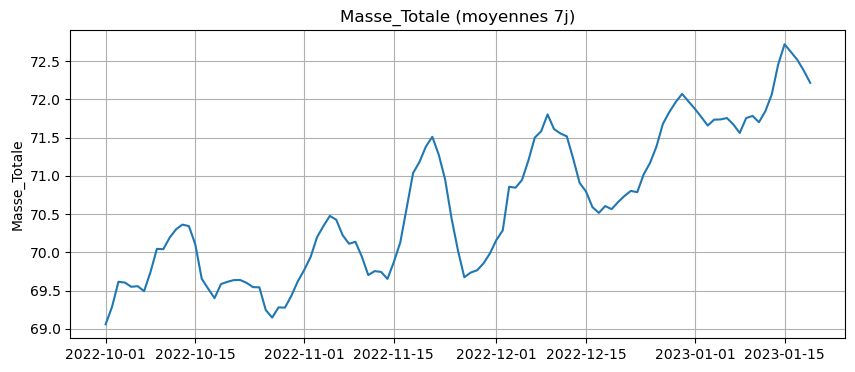

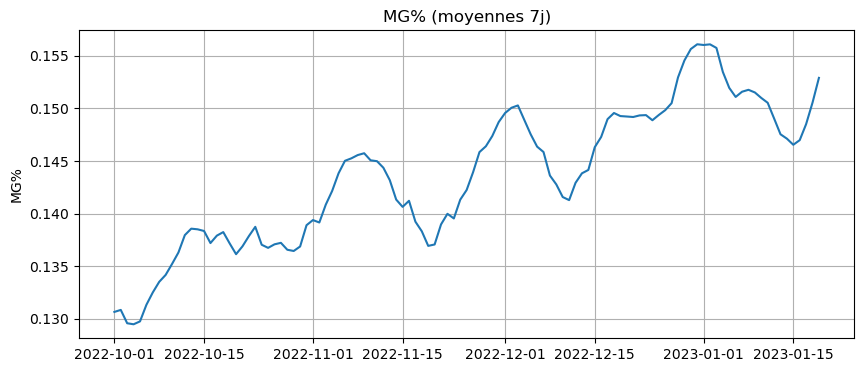

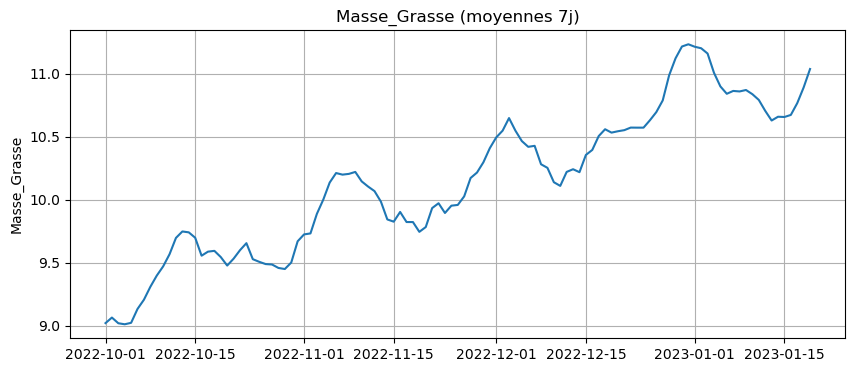

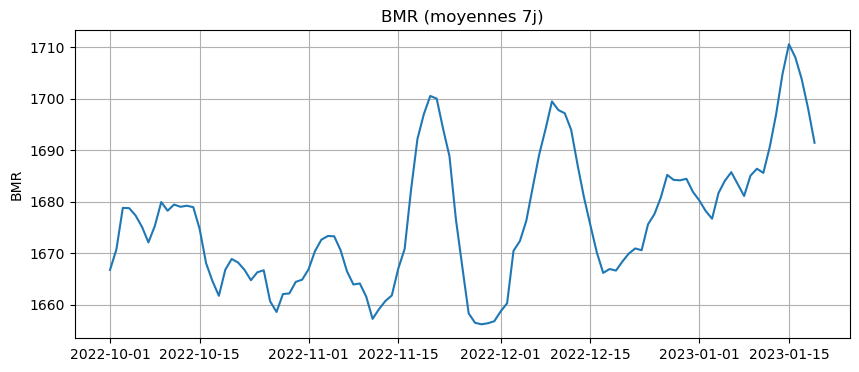

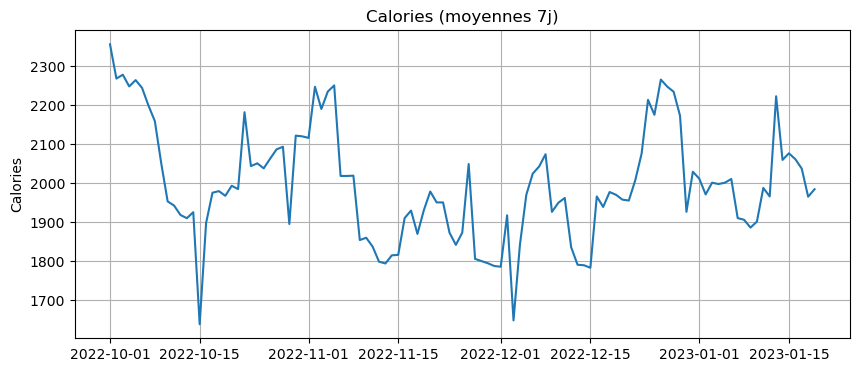

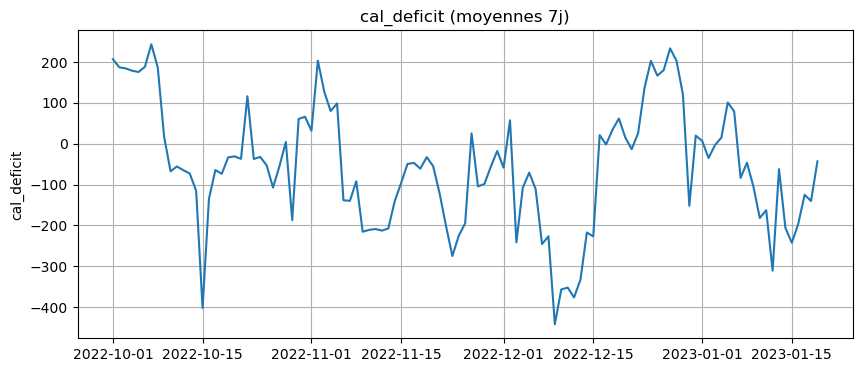

In [27]:
plot_general()

In [28]:
ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2021,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=7, description='longueur', max=90, min=1, step=7), IntSlider(value=2022,…

<function __main__.plot_general(longueur=7, year=2022, month=10, day=1)>

In [29]:
def plot_general2(longueur=7,
                 year=2022,
                 month=11,
                 day=1
):
    vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    df_all2 = df_all.rolling(longueur).mean().dropna()
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(10,4))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='x', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.12, top=0.16)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='o', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-300.0, top=300.0)
    # ax2.legend()

In [30]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2021,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=7, description='longueur', max=90, min=1, step=7), IntSlider(value=2022,…

<function __main__.plot_general2(longueur=7, year=2022, month=11, day=1)>